In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
from astropy.table import Table
# from scipy.spatial import distance
# from scipy import spatial
# from scipy.spatial import KDTree
import time
import matplotlib.path as mpltPath
from pandas import DataFrame, read_csv
import pandas as pd 
from mpl_toolkits.mplot3d import Axes3D
import copy
#from matplotlib.patches import Circle, Wedge, Polygon
#from matplotlib.collections import PatchCollection


In [2]:
file = r'Gaia_plx7_dr2.csv'
df = pd.read_csv(file)
df2 = df.columns.get_values()
df2.tolist()
print('Succesfully Read in the Data')

/astromake/opt/python/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (96,122,130) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Succesfully Read in the Data


In [3]:
# GAIA bands
Gmag = df["phot_g_mean_mag"].values
GBmag = df["phot_bp_mean_mag"].values
GRmag = df["phot_rp_mean_mag"].values
# 2MASS bands
Jmag = df["j_m"].values
Hmag = df["h_m"].values
Kmag = df["ks_m"].values
# SDSS Bands
u_mag = df["u_mag"].values
g_mag = df["g_mag"].values
r_mag = df["r_mag"].values
i_mag = df["i_mag"].values
z_mag = df["z_mag"].values
# Other Important Data
plx = df["parallax"].values
Dist = 1000./plx

In [4]:
def AbsoluteMagnitudes(plx,GBmag,GRmag,Gmag,Jmag,Hmag,Kmag,umag,gmag,rmag,imag,zmag):
    #Calculates the absolute magnitudes of the stars
    #Read in parallax and apparent magnitude from each band
    
    #Variables Read In
    #plx: column of parallaxes
    #GBmag: column of magnitudes in GB
    #GRmag: column of magnitudes in GR
    #Gmag: column of magnitudes in G
    #Jmag: column of magnitudes in J
    #Kmag: column of magnitudes in K
    #Hmag: column of magnitudes in H
    #umag: column of magnitudes in u
    #gmag: column of magnitudes in g
    #rmag: column of magnitudes in r
    #imag: column of magnitudes in i
    #zmag: column of magnitudes in z
    
    #Variables Returned
    #plx: column of parallaxes
    #GBmags: numpy array of absolute magnitudes in GB
    #GRmags: numpy array of absolute magnitudes in GR
    #Gmags: numpy array of absolute magnitudes in G
    #Jmags: numpy array of absolute magnitudes in J
    #Hmags: numpy array of absolute magnitudes in H
    #Kmags: numpy array of absolute magnitudes in K
    #umags: numpy array of absolute magnitudes in u
    #gmags: numpy array of absolute magnitudes in g
    #rmags: numpy array of absolute magnitudes in r
    #imags: numpy array of absolute magnitudes in i
    #zmags: numpy array of absolute magnitudes in z
        
    
    #create arrays for absolute magnitude
    Dist = np.array([])
    GBmags = np.array([])
    GRmags = np.array([])
    Gmags = np.array([])
    Jmags = np.array([])
    Hmags = np.array([])
    Kmags = np.array([])
    umags = np.array([])
    gmags = np.array([])
    rmags = np.array([])
    imags = np.array([])
    zmags = np.array([])
    
    #calculate the distance of each star in parsecs
    Dist = 1000./plx
    
    #use the distance modulus formula to calculate the absolute magnitude for all the stars
    GBmags = GBmag - 5 * np.log10(Dist) + 5
    GRmags = GRmag - 5 * np.log10(Dist) + 5
    Gmags = Gmag - 5 * np.log10(Dist) + 5
    Jmags = Jmag - 5 * np.log10(Dist) + 5
    Hmags = Hmag - 5 * np.log10(Dist) + 5
    Kmags = Kmag - 5 * np.log10(Dist) + 5
    umags = umag - 5 * np.log10(Dist) + 5
    gmags = gmag - 5 * np.log10(Dist) + 5
    rmags = rmag - 5 * np.log10(Dist) + 5
    imags = imag - 5 * np.log10(Dist) + 5
    zmags = zmag - 5 * np.log10(Dist) + 5
    
    return Dist, GBmags,GRmags,Gmags,Jmags,Hmags,Kmags,umags,gmags,rmags,imags,zmags


In [5]:
def ColorClassification(Gmags,Kmags,colors):    
    #assign the stars into different categories based on G-K
    
    #Variables Read In
    #Gmags: numpy array of absolute magnitudes in G
    #Kmags: numpy array of absolute magnitudes in K
    #colors: list or array of values of G-K in increasing order
    
    #Variables Returned
    #color: numpy array that indicates the category of G-K that each star belongs to
    
    #caclculate the values of G-K for all stars
    
    G_K = Gmags-Kmags
    
    #create array to hold the G-K color categories 
    color = np.ones(len(G_K))*1000
    
    #compare the value of G-K for each star to the categories and assign a corresponding
    #value for the category in the color array
    for i in range(len(colors)):
        for j in range(len(G_K)):
            if (i == 0):
                if (G_K[j] <= colors[i]):
                    color[j] = colors[i]
            elif(G_K[j] <= colors[i] and G_K[j] > colors[i-1]):
                color[j] = colors[i]
    return color

In [6]:
def CreateTemplates(color,colors,Gmags,Kmags,GB_mags=[999],GR_mags=[999],J_mags=[999],H_mags=[999],umags=[999],gmags=[999],rmags=[999],imags=[999],zmags=[999]):
    #For each category of G-K, a template is created of the absolute magnitudes of the stars and their color indices 
    #calculated with bands of different magnitudes
    # ** Gmags and Kmags is REQUIRED ** 
    #Variables Read In:
    #color: numpy array that indicates the category of G-K that each star belongs to
    #colors: list or array of values of G-K in increasing order
    #GBmags: numpy array of absolute magnitudes in GB
    #GRmags: numpy array of absolute magnitudes in GR
    #Gmags: numpy array of absolute magnitudes in G
    #Jmags: numpy array of absolute magnitudes in J
    #Hmags: numpy array of absolute magnitudes in H 
    #Kmags: numpy array of absolute magnitudes in K
    #umags: numpy array of absolute magnitudes in u
    #gmags: numpy array of absolute magnitudes in g
    #rmags: numpy array of absolute magnitudes in r
    #imags: numpy array of absolute magnitudes in i
    #zmags: numpy array of absolute magnitudes in z
    
    #Variables Returned: 
    #stars: array of the number of stars in each category of G-K
    #color_mags: array of the color indices at each wavelength for all of the categories of G-K
    #color_std: array of the standard deviation of color indices at each wavelength for all of the categories of G-K
    #color_std_err: array of the standard deviation error of thecolor indices at each wavelength for all of the categories of G-K
    #abs_color_mags: array of the average absolute magnitudes in each band for all of the categories of G-K
    #abs_color_std: array of the standard deviation of absolute magnitudes in each band for all of the categories of G-K
    #abs_color_std_err: array of the standard deviation error of absolute magnitudes in each band for all categores of G-K
    
    if(len(GB_mags) < 2):
        GB_mags = np.ones(len(Gmags))*np.nan
    if(len(GR_mags) < 2):
        GR_mags = np.ones(len(Gmags))*np.nan
    if(len(J_mags) < 2):
        J_mags = np.ones(len(Gmags))*np.nan
    if(len(H_mags) < 2):
        H_mags = np.ones(len(Gmags))*np.nan
    if(len(umags) < 2):
        umags = np.ones(len(Gmags))*np.nan
    if(len(gmags) < 2):
        gmags = np.ones(len(Gmags))*np.nan
    if(len(zmags) < 2):
        zmags = np.ones(len(Gmags))*np.nan
    if(len(imags) < 2):
        imags = np.ones(len(Gmags))*np.nan
    if(len(rmags) < 2):
        rmags = np.ones(len(Gmags))*np.nan
    
    
    #Calculate the values of G-K for each star
    G_K = Gmags-Kmags
    
    #create array to hold the number of stars in each template: 
    stars = np.array([])
    
    for c in colors:
        #create array of values for color indices and absolute magnitudes
        G_GB_array = np.array([])
        G_GR_array = np.array([])
        G_J_array = np.array([])
        G_H_array = np.array([])
        G_K_array = np.array([])
        G_u_array = np.array([])
        G_g_array = np.array([])
        G_r_array = np.array([])
        G_i_array = np.array([])
        G_z_array = np.array([])
        GB = np.array([])
        GR = np.array([])
        G = np.array([])
        J = np.array([])
        H = np.array([])
        K = np.array([])
        u = np.array([])
        g = np.array([])
        r = np.array([])
        i_m = np.array([])
        z = np.array([])
        star_count = 0
        #fill arrays with values if the values are part of the color category
        for i in range(len(Gmags)):
            if (color[i] == c):
                
                G_GB_array = np.append(G_GB_array,Gmags[i]-GB_mags[i])
                G_GR_array = np.append(G_GR_array,Gmags[i]-GR_mags[i])
                G_J_array = np.append(G_J_array,Gmags[i]-J_mags[i])
                G_H_array = np.append(G_H_array,Gmags[i]-H_mags[i])
                G_K_array = np.append(G_K_array,Gmags[i]-Kmags[i])
                G_u_array = np.append(G_u_array,Gmags[i]-umags[i])
                G_g_array = np.append(G_g_array,Gmags[i]-gmags[i])
                G_r_array = np.append(G_r_array,Gmags[i]-rmags[i])
                G_i_array = np.append(G_i_array,Gmags[i]-umags[i])
                G_z_array = np.append(G_z_array,Gmags[i]-zmags[i])
                GB = np.append(GB,GB_mags[i])
                GR = np.append(GR,GR_mags[i])
                G = np.append(G,Gmags[i])
                J = np.append(J,J_mags[i])
                H = np.append(H,H_mags[i])
                K = np.append(K,Kmags[i])
                u = np.append(u,umags[i])
                g = np.append(g,umags[i])
                r = np.append(r,rmags[i])
                i_m = np.append(i_m,imags[i])
                z = np.append(z,zmags[i])
                star_count = star_count +1
        #number of stars per color
        stars = np.append(stars,star_count)
        #relative SED
        mag_array = [np.nanmean(G_u_array),np.nanmean(G_g_array), np.nanmean(G_GB_array),\
                     np.nanmean(G_r_array),np.nanmean(G_i_array), np.nanmean(G_GR_array), \
                     np.nanmean(G_z_array),np.nanmean(G_J_array), np.nanmean(G_H_array), \
                     np.nanmean(G_K_array)]
        std_array = [np.nanstd(G_u_array),np.nanstd(G_g_array), np.nanstd(G_GB_array),\
                     np.nanstd(G_r_array),np.nanstd(G_i_array), np.nanstd(G_GR_array), \
                     np.nanstd(G_z_array),np.nanstd(G_J_array), np.nanstd(G_H_array), \
                     np.nanstd(G_K_array)]
        #absolute SED
        mag_array2 = [np.nanmean(u), np.nanmean(g), np.nanmean(GB), \
                      np.nanmean(r), np.nanmean(G), np.nanmean(i), \
                      np.nanmean(GR), np.nanmean(z), np.nanmean(J), \
                      np.nanmean(H), np.nanmean(K)]
        std_array2 = [np.nanstd(u), np.nanstd(g), np.nanstd(GB), \
                      np.nanstd(r), np.nanstd(G), np.nanstd(i_m), \
                      np.nanstd(GR), np.nanstd(z), np.nanstd(J), \
                      np.nanstd(H), np.nanstd(K)]
        #calculate standard deviation error
        val = np.sqrt(len(G_u_array))
        std_array3 = std_array/val
        val2 = np.sqrt(len(u))
        std_array4 = std_array2/val2
        #stack SEDs
        if (c == colors[0]):
            
            color_mags = np.array(mag_array)
            color_std = np.array(std_array)
            color_std_err = np.array(std_array3)
            abs_color_mags = np.array(mag_array2)
            abs_color_std = np.array(std_array2)
            abs_color_std_err = np.array(std_array4)
        else:
            #print(len(color_mags),len(mag_array))
            color_mags = np.vstack((color_mags,mag_array))
            color_std = np.vstack((color_std,std_array))
            color_std_err = np.vstack((color_std_err,std_array3))
            #print('\n',len(abs_color_mags),len(mag_array2))
            abs_color_mags = np.vstack((abs_color_mags, mag_array2))
            abs_color_std = np.vstack((abs_color_mags, std_array2))
            abs_color_std_err = np.vstack((abs_color_std_err,std_array4))
            #A[~np.isnan(A)])
    #print((color_mags))
#     color_mags = color_mags[~np.isnan(color_mags)]
#     #print(len(color_mags))
#     color_std = color_std[~np.isnan(color_std)]
#     color_std_err = color_std_err[~np.isnan(color_std_err)]
#     abs_color_mags = abs_color_mags[~np.isnan(abs_color_mags)]
#     abs_color_std = abs_color_std[~np.isnan(abs_color_std)]
#     abs_color_std_err = abs_color_std_err[~np.isnan(abs_color_std_err)]
#     color_mags = np.reshape(color_mags, (-1, 10))
#     color_std = np.reshape(color_std, (-1, 10))
#     color_std_err = np.reshape(color_std_err, (-1, 10))
#     print(color_mags,'\n',abs_color_mags)
#     abs_color_mags = np.reshape(abs_color_mags, (-1, 11))
#     abs_color_std = np.reshape(abs_color_std, (-1, 11))
#     abs_color_std_err = np.reshape(abs_color_std_err, (-1, 11))
            
    return stars,color_mags,color_std,color_std_err,abs_color_mags,abs_color_std,abs_color_std_err

In [7]:
def CreatePlots(colors,abs_colors_mags,abs_color_std,color_mags,color_std):
    #create SED and Relative SED plots with the standard deviation as error 
    
    #Variables Read In:
    #colors: list or array of values of G-K in increasing order
    #wvl: list of colors that contain the wavlengths of the filters except for the G filter
    #wvl2: list of colors that contain the wavlengths of the filters
    #stars: array of the number of stars in each category of G-K
    #abs_color_mags: array of the average absolute magnitudes in each band for all of the categories of G-K
    #abs_color_std: array of the standard deviation of absolute magnitudes in each band for all of the categories of G-K
    #color_mags: array of the color indices at each wavelength for all of the categories of G-K
    #color_std: array of the standard deviation of color indices at each wavelength for all of the categories of G-K 
    
    #No variables are read out, running the function creates two plots
    
    wvl = [354,420,477,500,623,677,763,913,1250,1650,2170]
    wvl2 = [354,420,477,623,677,763,913,1250,1650,2170]
    new_wvl = []
    new_wvl2 = []
    for i in range(len(abs_color_mags[0])):
        if(str(abs_color_mags[0,i]) != 'nan'):
            new_wvl.append(wvl[i])
            
    for i in range(len(color_mags[0])):
        if(str(color_mags[0,i]) != 'nan'):
            new_wvl2.append(wvl2[i])
    #print(wvl,'\n',wvl2)
#     wvl = wvl[~np.isnan(wvl)]
#     wvl2 = wvl2[~np.isnan(wvl2)]
    
    
    #plot average absolute magnitude in each filter for each value of G-K 
    ax = plt.subplot(111)
    for i in range(len(colors)):
        #color_mags = color_mags[~np.isnan(color_mags)]
        acm = abs_color_mags[i,:]
        acs = abs_color_std[i,:]
        
        acm = acm[~np.isnan(acm)]
        acs = acs[~np.isnan(acs)]
        
        ax.errorbar(new_wvl, acm, yerr = acs, linestyle = '-', marker = 'o',label = str(colors[i]))
       ## ORIGINAL CODE
        #ax.errorbar(wvl, abs_color_mags[i,:], yerr = abs_color_std[i,:], linestyle = '-', marker = 'o',label = str(colors[i]))
    ax.set_xlabel('Effective Wavelength (nm)')
    ax.set_ylabel('Average Absolute Magnitude')
    ax.set_title('Spectral Energy Distribution')
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    #plot average color index in each filter for each value of G-K
    ax2 = plt.subplot(111)
    for i in range(len(colors)):
        acm = color_mags[i,:]
        acs = color_std[i,:]
        c = str(colors[i])
        acm = acm[~np.isnan(acm)]
        acs = acs[~np.isnan(acs)]
        #print(acm,'\n',new_wvl2)
        ax2.errorbar(new_wvl2, acm, yerr = acs, linestyle = '-', marker = 'o',label = str(colors[i]))
        
       
        #ax2.errorbar(wvl2, color_mags[i,:], yerr = color_std[i,:], linestyle = '-', marker = 'o',label = str(colors[i]))
    ax2.set_xlabel('Effective Wavelength (nm)')
    ax2.set_ylabel('Average Color Index')
    ax2.set_title('Spectral Energy Distribution')
    box2 = ax.get_position()
    ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    return

In [121]:
# DEFINE HOW MANY TEMPLATES YOU WANT TO PLOT BASED ON G-K COLOR
Gmags = Gmag - 5 * np.log10(Dist) + 5

new_Gmag = []
new_GBmag = []
new_GRmag = []
new_Jmag = []
new_Hmag = []
new_Kmag = []

for i in range(len(Gmags)):
    if(Gmags[i] < 7):
        new_Gmag.append(Gmag[i])
        new_GBmag.append(GBmag[i])
        new_GRmag.append(GRmag[i])
        new_Jmag.append(Jmag[i])
        new_Hmag.append(Hmag[i])
        new_Kmag.append(Kmag[i])
new_Gmag = np.array(new_Gmag)
new_GBmag = np.array(new_GBmag)
new_GRmag = np.array(new_GRmag)
new_Jmag = np.array(new_Jmag)
new_Hmag = np.array(new_Hmag)
new_Kmag = np.array(new_Kmag)
        
colors = np.arange(0.3,3,0.07) # EDIT THIS TO USE DESIRED NUMBER OF COLORS
#color = ColorClassification(new_Gmag,new_Kmag,colors)
color = ColorClassification(Gmag,Kmag,colors)


# stars,color_mags,color_std,color_std_err,abs_color_mags,abs_color_std,abs_color_std_err = \
# CreateTemplates(color,colors,new_Gmag,new_Kmag,GB_mags=new_GBmag,GR_mags=new_GRmag,J_mags=new_Jmag,H_mags=new_Hmag)


stars,color_mags,color_std,color_std_err,abs_color_mags,abs_color_std,abs_color_std_err = \
CreateTemplates(color,colors,Gmag,Kmag,GB_mags=GBmag,GR_mags=GRmag,J_mags=Jmag,H_mags=Hmag)

/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: Mean of empty slice
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:111: RuntimeWarning: Mean of empty slice


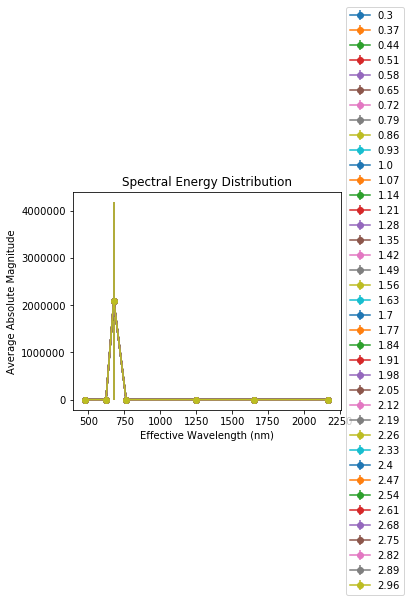

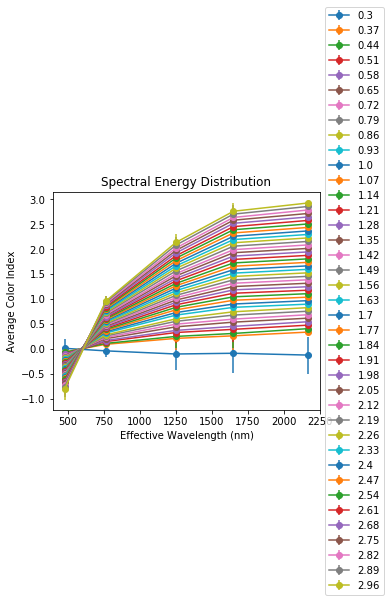

In [129]:


CreatePlots(colors,abs_color_mags,abs_color_std,color_mags,color_std)

In [48]:
n =5
starBands = [new_Gmag[n],new_GBmag[n],new_GRmag[n],new_Jmag[n],new_Hmag[n],new_Kmag[n]]
print(starBands)

new_starBands = []
for i in range(len(starBands)):
    if(i == 0):
        G = starBands[i]
    else:
        G_X = G - starBands[i]
        new_starBands.append(G_X)
print(new_starBands)

[10.882441520690918, 11.388130187988279, 10.248380661010742, 9.5019998550415039, 9.074000358581543, 8.9209995269775391]
[-0.5056886672973615, 0.63406085968017578, 1.3804416656494141, 1.808441162109375, 1.9614419937133789]


In [58]:
# ONLY GAIA BANDS AND 2MASS BANDS
def StarFitting(starBands,color_mags,color_std):
    new_starBands = []
    for i in range(len(starBands)):
        if(i == 0):
            G = starBands[i]
        else:
            G_X = G - starBands[i]
            new_starBands.append(G_X)
    
    template_bands = []
    template_err = []
    for i in range(len(color_mags)):
        cm = color_mags[i,:]
        cm = cm[~np.isnan(cm)]
        cs = color_std[i,:]
        cs = cs[~np.isnan(cs)]
        template_bands.append(cm)
        template_err.append(cs)
    template_bands = np.array(template_bands)
    template_err = np.array(template_err)
    
    Chi2_vals = []
    for i in range(len(template_bands)):
        Chi2 = 0
        for j in range(len(new_starBands)):
            Chi2 = Chi2 + ((template_bands[i,j] - new_starBands[j])**2/(template_err[i,j])**2)
        Chi2 = Chi2/(len(new_starBands)-1)
        Chi2_vals.append(Chi2)
    Chi2_vals = np.array(Chi2_vals)
    red_Chi2 = []
    for i in range(len(Chi2_vals)):
        if(Chi2_vals[i] == np.min(Chi2_vals)):
            chi_val = Chi2_vals[i]
            red_Chi2.append(chi_val)
            best_fit = i
#             print('The best Template is '+ str((best_fit+1)) +' out of '+str(len(template_bands))+ ' templates')
#             print('Or ' + str(best_fit) + ' out of ' + str((len(template_bands)-1)))
    #print(best_fit)
    return best_fit, new_starBands, red_Chi2    

In [79]:
fit, new_starBands,chi2 = StarFitting(starBands,color_mags,color_std)



new_starBands = []
for i in range(len(starBands)):
    if(i == 0):
        G = starBands[i]
    else:
        G_X = G - starBands[i]
        new_starBands.append(G_X)
# print(new_starBands)

# print('\n\n\n\n\n',color_mags,'\n\n',new_starBands)
print(fit)
print(chi2)

24
[0.26070241921177928]


In [130]:
all_starBands = []
for i in range(len(Gmag)):
    if(Gmag[i] != np.nan and GBmag[i] != np.nan and GRmag[i] != np.nan and Jmag[i] \
       != np.nan and Hmag[i] != np.nan and Kmag[i] != np.nan and \
       (Gmag[i]-Kmag[i]) <=3.0 and (Gmag[i]-Kmag[i]) >= 0.3 and (Gmag[i] - Kmag[i]) != np.nan \
      and (Gmag[i]-Hmag[i]) != np.nan):
        
        all_starBands.append([Gmag[i],GBmag[i],GRmag[i],Jmag[i],Hmag[i],Kmag[i]])
all_starBands = np.array(all_starBands)
print(all_starBands[0])

[ 10.02853012  10.37783909   9.54774475   8.99300003   8.68599987
   8.65100002]


In [131]:
star_bin_vals = []
temp_bin_vals = []
red_Chi2_vals = []

for i in range(len(all_starBands)):
    
    starBands= np.array(all_starBands[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_starBands[0])):
        #starBands = np.array(starBands)
        fit, new_starBand, red_Chi2 = StarFitting(starBands,color_mags,color_std)
        temp_bin_vals.append(colors[fit])
        red_Chi2_vals.append(red_Chi2)
        diff_vals = []
        for j in range(len(colors)):
            diff = abs(colors[j] - new_starBand[4])
            diff_vals.append(diff)

        for j in range(len(diff_vals)):
            if(diff_vals[j] == np.min(diff_vals)):
                star_bin_vals.append(colors[j])


 # **Comparing Reduced Chi2 value for each G-K Interval**

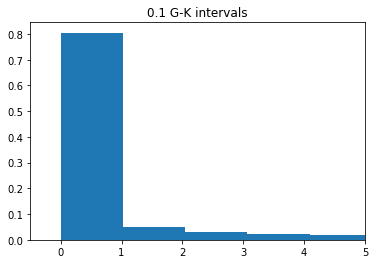

Average Reduced Chi2 Val: 1.25959241862
Median Reduced Chi2 Val: 0.416214103869
STD of Reduced Chi2 Val: 3.33696301491


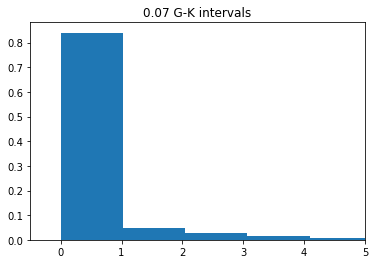

Average Reduced Chi2 Val: 1.09487917538
Median Reduced Chi2 Val: 0.380570872118
STD of Reduced Chi2 Val: 3.3337648876


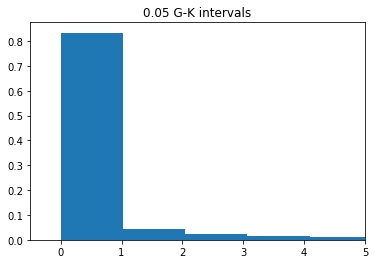

Average Reduced Chi2 Val: 1.16227407892
Median Reduced Chi2 Val: 0.381068868168
STD of Reduced CHi2 Val: 3.43854138419


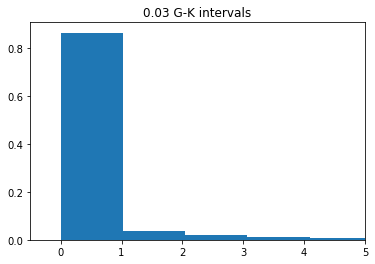

Average Reduced Chi2 Val: 1.04785069795
Median Reduced Chi2 Val: 0.359756314394
STD of Reduced Chi2 Val: 3.37811816912


In [195]:
# red_Chi2_vals = np.array(red_Chi2_vals)
# red_Chi2_vals_07 = copy.copy(red_Chi2_vals)

plt.hist(red_Chi2_vals_1[:,0],200,normed=True)
plt.xlim([-.5,5])
plt.title('0.1 G-K intervals')
plt.show()
print('Average Reduced Chi2 Val:', np.mean(red_Chi2_vals_1[:,0]))
print('Median Reduced Chi2 Val:', np.median(red_Chi2_vals_1[:,0]))
print('STD of Reduced Chi2 Val:', np.std(red_Chi2_vals_1[:,0]))

plt.hist(red_Chi2_vals_07[:,0],200,normed=True)
plt.xlim([-.5,5])
plt.title('0.07 G-K intervals')
plt.show()
print('Average Reduced Chi2 Val:', np.mean(red_Chi2_vals_07[:,0]))
print('Median Reduced Chi2 Val:', np.median(red_Chi2_vals_07[:,0]))
print('STD of Reduced Chi2 Val:', np.std(red_Chi2_vals_07[:,0]))

plt.hist(red_Chi2_vals_05[:,0],200,normed=True)
plt.xlim([-.5,5])
plt.title('0.05 G-K intervals')
plt.show()
print('Average Reduced Chi2 Val:', np.mean(red_Chi2_vals_05[:,0]))
print('Median Reduced Chi2 Val:', np.median(red_Chi2_vals_05[:,0]))
print('STD of Reduced CHi2 Val:', np.std(red_Chi2_vals_05[:,0]))

plt.hist(red_Chi2_vals_03[:,0],200,normed=True)
plt.xlim([-.5,5])
plt.title('0.03 G-K intervals')
plt.show()
print('Average Reduced Chi2 Val:', np.mean(red_Chi2_vals_03[:,0]))
print('Median Reduced Chi2 Val:', np.median(red_Chi2_vals_03[:,0]))
print('STD of Reduced Chi2 Val:', np.std(red_Chi2_vals_03[:,0]))


# **Plots using G-K color ranges of 0.3 to 3.0 using 0.1 G-K sub-intervals**

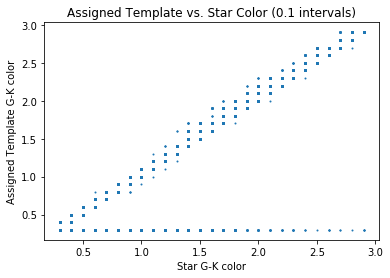

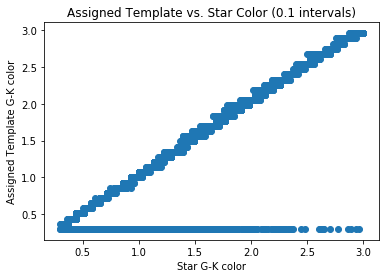

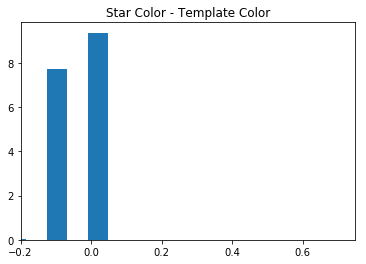

Mean: -0.0401077935458


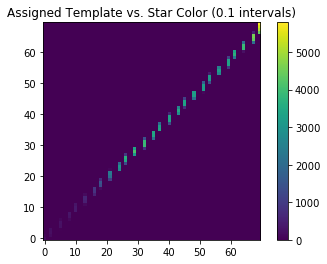

In [196]:
# DEFINE AND COPY ARRAYS BEING CREATED IN SCRIPT ABOVE. ENSURE YOU CHANGE THE NAME OF THE COPIED VARIABLE
# star_bin_vals = np.array(star_bin_vals)
# temp_bin_vals = np.array(temp_bin_vals)

# star_bin_vals_1 = copy.copy(star_bin_vals)
# temp_bin_vals_1 = copy.copy(temp_bin_vals) KEEP THESE 4 LINES COMMENTED OUT UNLESS BEING USED

# PLOT CURVE RELATING STAR COLOR AND ASSIGNED TEMPLATE COLOR WHERE STAR COLOR IS DIGITIZED
plt.scatter(star_bin_vals_1,temp_bin_vals_1,s=1.0)
plt.title('Assigned Template vs. Star Color (0.1 intervals)')
plt.xlabel('Star G-K color')
plt.ylabel('Assigned Template G-K color')
plt.show()

# CREATING SAME CURVE WHERE STAR COLOR IS NOT DIGITIZED
diff_1 = []
for i in range(len(all_starBands)):
    starBands= np.array(all_starBands[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_starBands[0])):
        diff_1.append(starBands[0] - starBands[5])
diff_1 = np.array(diff_1)


plt.scatter(diff_1,temp_bin_vals)
plt.title('Assigned Template vs. Star Color (0.1 intervals)')
plt.xlabel('Star G-K color')
plt.ylabel('Assigned Template G-K color')
plt.show()

# CREATING HISTOGRAM OF THE DIFFERENCE BETWEEN STAR COLOR AND TEMPLATE COLOR
difference_1 = star_bin_vals_1-temp_bin_vals_1

bins_1 = plt.hist(difference_1,50,normed=True)
plt.title('Star Color - Template Color')
plt.xlim([-0.2,0.75])
plt.show()
print('Mean:',np.mean(difference_1))

# CREATING HEATMAP OF THE FIRST TWO PLOTS ABOVE
heatmap, xedges, yedges = np.histogram2d(star_bin_vals_1, diff_1, bins=70)
plt.imshow(heatmap.T, origin='lower')
plt.title('Assigned Template vs. Star Color (0.1 intervals)')
plt.colorbar()
plt.show()

# **Plots using G-K color ranges of 0.3 to 3.0 using 0.07 G-K sub-intervals**

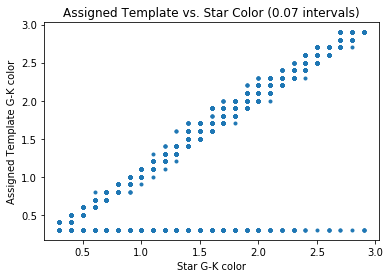

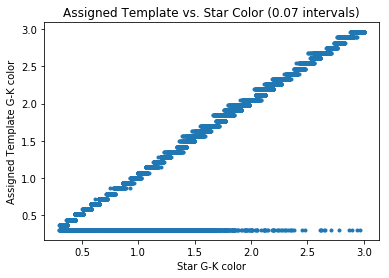

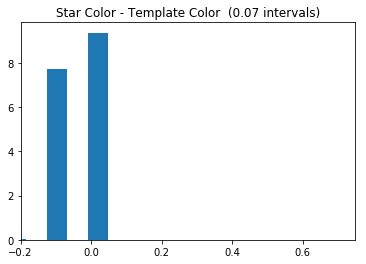

Mean: -0.0401077935458


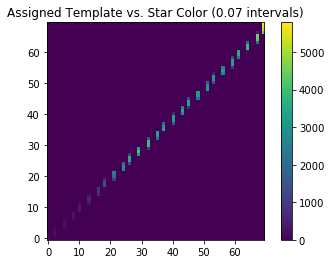

In [185]:
# DEFINE AND COPY ARRAYS BEING CREATED IN SCRIPT ABOVE. ENSURE YOU CHANGE THE NAME OF THE COPIED VARIABLE
# star_bin_vals = np.array(star_bin_vals)
# temp_bin_vals = np.array(temp_bin_vals)

# star_bin_vals_07 = copy.copy(star_bin_vals)
# temp_bin_vals_07 = copy.copy(temp_bin_vals) KEEP THESE 4 LINES COMMENTED OUT UNLESS BEING USED

# PLOT CURVE RELATING STAR COLOR AND ASSIGNED TEMPLATE COLOR WHERE STAR COLOR IS DIGITIZED
plt.plot(star_bin_vals_07,temp_bin_vals_07,'.')
plt.title('Assigned Template vs. Star Color (0.07 intervals)')
plt.xlabel('Star G-K color')
plt.ylabel('Assigned Template G-K color')
plt.show()

# CREATING SAME CURVE WHERE STAR COLOR IS NOT DIGITIZED
diff_07 = []
for i in range(len(all_starBands)):
    starBands= np.array(all_starBands[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_starBands[0])):
        diff_07.append(starBands[0] - starBands[5])
diff_07 = np.array(diff_07)


plt.plot(diff_07,temp_bin_vals,'.')
plt.title('Assigned Template vs. Star Color (0.07 intervals)')
plt.xlabel('Star G-K color')
plt.ylabel('Assigned Template G-K color')
plt.show()

# CREATING HISTOGRAM OF THE DIFFERENCE BETWEEN STAR COLOR AND TEMPLATE COLOR
difference_07 = star_bin_vals_07-temp_bin_vals_07

bins_07 = plt.hist(difference_07,50,normed=True)
plt.title('Star Color - Template Color  (0.07 intervals)')
plt.xlim([-0.2,0.75])
plt.show()
print('Mean:',np.mean(difference_07))
# CREATING HEATMAP OF THE FIRST TWO PLOTS ABOVE
heatmap, xedges, yedges = np.histogram2d(star_bin_vals_07, diff_07, bins=70)
plt.imshow(heatmap.T, origin='lower')
plt.title('Assigned Template vs. Star Color (0.07 intervals)')
plt.colorbar()
plt.show()

# **Plots using G-K color ranges of 0.3 to 3.0 using 0.05 G-K sub-intervals**

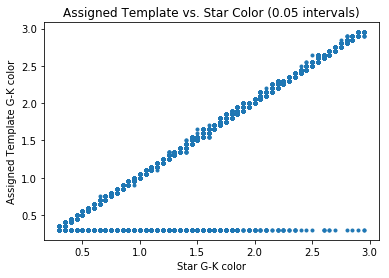

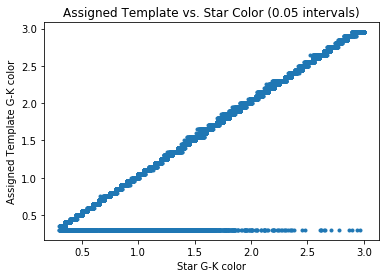

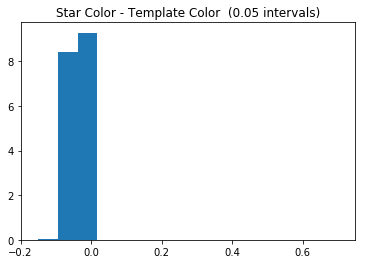

Mean: -0.0177724738153


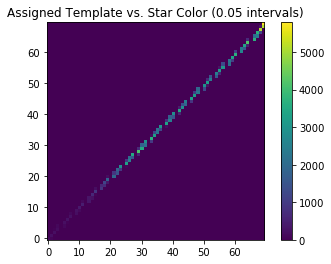

In [186]:
# DEFINE AND COPY ARRAYS BEING CREATED IN SCRIPT ABOVE. ENSURE YOU CHANGE THE NAME OF THE COPIED VARIABLE
# star_bin_vals = np.array(star_bin_vals)
# temp_bin_vals = np.array(temp_bin_vals)

# star_bin_vals_05 = copy.copy(star_bin_vals)
# temp_bin_vals_05 = copy.copy(temp_bin_vals) KEEP THESE 4 LINES ABOVE COMMENTED OUT UNLESS BEING USED

# PLOT CURVE RELATING STAR COLOR AND ASSIGNED TEMPLATE COLOR WHERE STAR COLOR IS DIGITIZED
plt.plot(star_bin_vals_05,temp_bin_vals_05,'.')
plt.title('Assigned Template vs. Star Color (0.05 intervals)')
plt.xlabel('Star G-K color')
plt.ylabel('Assigned Template G-K color')
plt.show()

# CREATING SAME CURVE WHERE STAR COLOR IS NOT DIGITIZED
diff_05 = []
for i in range(len(all_starBands)):
    starBands= np.array(all_starBands[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_starBands[0])):
        diff_05.append(starBands[0] - starBands[5])
diff_05 = np.array(diff_05)


plt.plot(diff_05,temp_bin_vals_05,'.')
plt.title('Assigned Template vs. Star Color (0.05 intervals)')
plt.xlabel('Star G-K color')
plt.ylabel('Assigned Template G-K color')
plt.show()

# CREATING HISTOGRAM OF THE DIFFERENCE BETWEEN STAR COLOR AND TEMPLATE COLOR
difference_05 = star_bin_vals_05-temp_bin_vals_05

bins_05 = plt.hist(difference_05,50,normed=True)
plt.title('Star Color - Template Color  (0.05 intervals)')
plt.xlim([-0.2,0.75])
plt.show()
print('Mean:',np.mean(difference_05))

# CREATING HEATMAP OF THE FIRST TWO PLOTS ABOVE
heatmap, xedges, yedges = np.histogram2d(star_bin_vals_05, diff_05, bins=70)
plt.imshow(heatmap.T, origin='lower')
plt.title('Assigned Template vs. Star Color (0.05 intervals)')
plt.colorbar()
plt.show()

# **Plots using G-K color ranges of 0.3 to 3.0 using 0.03 G-K sub-intervals**

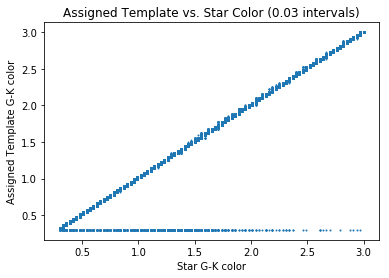

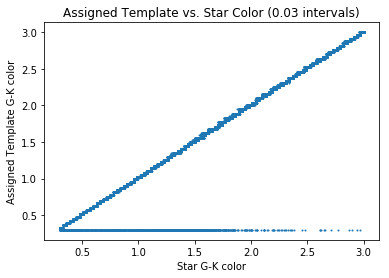

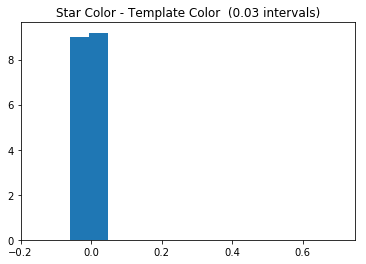

Mean: -0.00871605564674


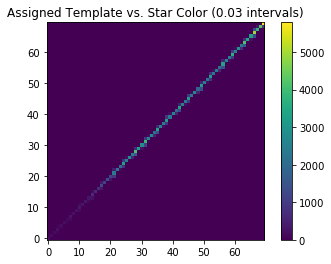

In [187]:
# DEFINE AND COPY ARRAYS BEING CREATED IN SCRIPT ABOVE. ENSURE YOU CHANGE THE NAME OF THE COPIED VARIABLE
# star_bin_vals = np.array(star_bin_vals)
# temp_bin_vals = np.array(temp_bin_vals)

# star_bin_vals_03 = copy.copy(star_bin_vals)
# temp_bin_vals_03 = copy.copy(temp_bin_vals) #KEEP THESE 4 LINES COMMENTED OUT UNLESS BEING USED

# PLOT CURVE RELATING STAR COLOR AND ASSIGNED TEMPLATE COLOR WHERE STAR COLOR IS DIGITIZED
plt.scatter(star_bin_vals_03,temp_bin_vals_03,s=1.0)
plt.title('Assigned Template vs. Star Color (0.03 intervals)')
plt.xlabel('Star G-K color')
plt.ylabel('Assigned Template G-K color')
plt.show()

# CREATING SAME CURVE WHERE STAR COLOR IS NOT DIGITIZED
diff_03 = []
for i in range(len(all_starBands)):
    starBands= np.array(all_starBands[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_starBands[0])):
        diff_03.append(starBands[0] - starBands[5])
diff_03 = np.array(diff_03)


plt.scatter(diff_03,temp_bin_vals_03,s=1.0)
plt.title('Assigned Template vs. Star Color (0.03 intervals)')
plt.xlabel('Star G-K color')
plt.ylabel('Assigned Template G-K color')
plt.show()

# CREATING HISTOGRAM OF THE DIFFERENCE BETWEEN STAR COLOR AND TEMPLATE COLOR
difference_03 = star_bin_vals_03-temp_bin_vals_03

bins_03 = plt.hist(difference_03,50,normed=True)
plt.title('Star Color - Template Color  (0.03 intervals)')
plt.xlim([-0.2,0.75])
plt.show()
print('Mean:',np.mean(difference_03))
# CREATING HEATMAP OF THE FIRST TWO PLOTS ABOVE
heatmap, xedges, yedges = np.histogram2d(star_bin_vals_03, diff_03, bins=70)
plt.imshow(heatmap.T, origin='lower')
plt.title('Assigned Template vs. Star Color (0.03 intervals)')
plt.colorbar()
plt.show()



In [164]:
er_stars = []
good_stars = []

for i in range(len(star_bin_vals_03)):
    if(star_bin_vals_03[i] > 0.3 and temp_bin_vals_03[i] == np.min(temp_bin_vals_03)):
        er_stars.append([star_bin_vals_03[i],temp_bin_vals_03[i],red_Chi2_vals[i,0]])
    else:
        good_stars.append([star_bin_vals_03[i],temp_bin_vals_03[i],red_Chi2_vals[i,0]])

er_stars = np.array(er_stars)
good_stars = np.array(good_stars)




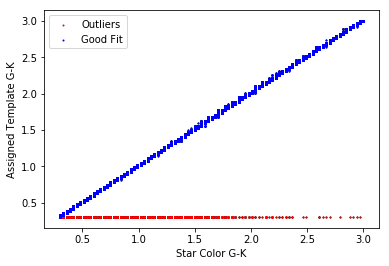

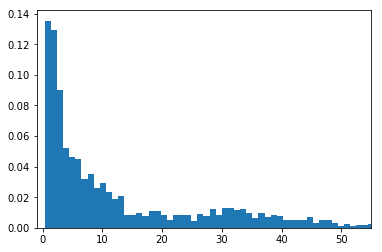

Mean Reduced Chi2: 12.9414262582


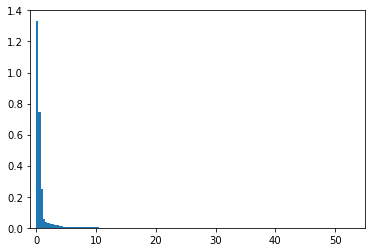

Mean Reduced Chi2: 1.00720157842


In [172]:
plt.scatter(star_bin_vals_03,temp_bin_vals_03,s=1.0,c='k')
plt.scatter(er_stars[:,0],er_stars[:,1],s=1,c='r',label= 'Outliers')
plt.scatter(good_stars[:,0],good_stars[:,1],s=1,c='b',label='Good Fit')
plt.legend()
plt.xlabel('Star Color G-K')
plt.ylabel('Assigned Template G-K')
plt.show()


plt.hist(er_stars[:,2],200,normed=True)
plt.xlim([-1,55])
plt.show()
print('Mean Reduced Chi2:',np.mean(er_stars[:,2]))

plt.hist(good_stars[:,2],200,normed=True)
plt.xlim([-1,55])
plt.show()
print('Mean Reduced Chi2:',np.mean(good_stars[:,2]))


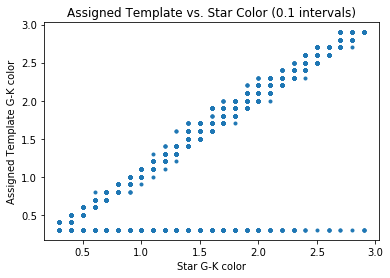

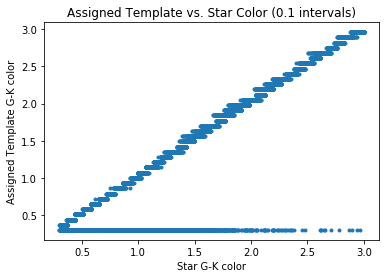

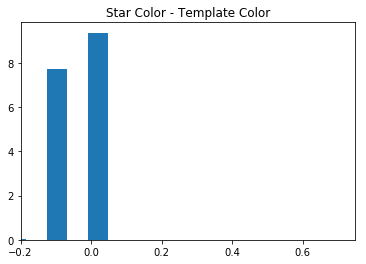

Mean: -0.0401077935458


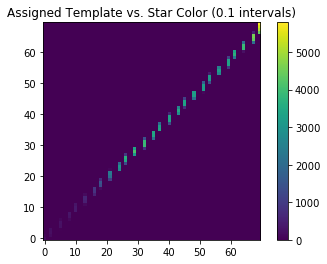

193147 193147


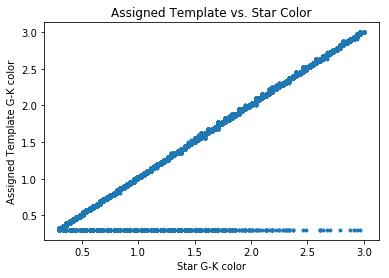

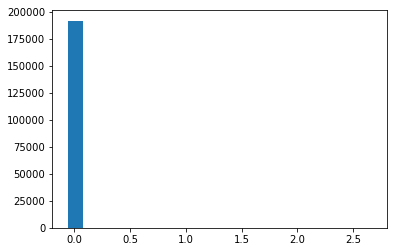

nan
[ 11.42688274  11.89881611  10.81965733  10.10099983   9.62100029
   9.56299973]


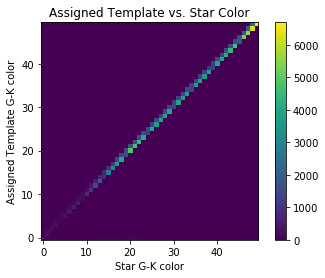

In [111]:
print(len(star_bin_vals),len(temp_bin_vals))

star_bin_vals = np.array(star_bin_vals)
temp_bin_vals = np.array(temp_bin_vals)
plt.plot(star_bin_vals,temp_bin_vals,'.')
plt.title('Assigned Template vs. Star Color')
plt.xlabel('Star G-K color')
plt.ylabel('Assigned Template G-K color')
plt.show()



difference = star_bin_vals-temp_bin_vals

bins_05 = plt.hist(difference,20)
plt.show()

print(Gmag[5704] - Kmag[5704])
print(all_starBands[5705])

heatmap, xedges, yedges = np.histogram2d(star_bin_vals, temp_bin_vals, bins=50)
plt.imshow(heatmap.T, origin='lower')
plt.title('Assigned Template vs. Star Color')
plt.xlabel('Star G-K color')
plt.ylabel('Assigned Template G-K color')
plt.colorbar()
plt.show()

In [203]:
# import pickle


# with open('03_variables.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#     pickle.dump([red_Chi2_vals_03, star_bin_vals_03, temp_bin_vals_03], f)
    

    
with open('03_variables.pkl') as f:  # Python 3: open(..., 'rb')
    red_Chi2_vals_03, star_bin_vals_03, temp_bin_vals_03 = pickle.load(f)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

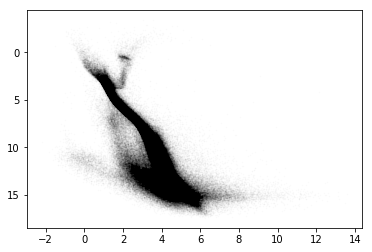

In [72]:
Dist = 1000./plx


GK = Gmag - Kmag
Gmags = Gmag - 5 * np.log10(Dist) + 5

# new_Gmag = []
# for i in range(len(Gmags)):
#     if(Gmags[i] < 9):
#         new_Gmag.append(Gmag[i])
plt.scatter(GK,Gmags,s=1.0,alpha=0.01,c='k')
plt.gca().invert_yaxis()
plt.show()

In [301]:
new_all_starBands = []
for i in range(len(new_Gmag)):
    if(new_Gmag[i] != np.nan and new_GBmag[i] != np.nan and new_GRmag[i] != np.nan and new_Jmag[i] \
       != np.nan and new_Hmag[i] != np.nan and new_Kmag[i] != np.nan and \
       (new_Gmag[i]-new_Kmag[i]) <=2.8 and (new_Gmag[i]-new_Kmag[i]) >= 0.2 and (new_Gmag[i] - new_Kmag[i]) != np.nan \
      and (new_Gmag[i]-new_Hmag[i]) != np.nan):
        
        new_all_starBands.append([new_Gmag[i],new_GBmag[i],new_GRmag[i],new_Jmag[i],new_Hmag[i],new_Kmag[i]])
new_all_starBands = np.array(all_starBands)
print(new_all_starBands[0])

[ 10.02853012  10.37783909   9.54774475   8.99300003   8.68599987
   8.65100002]


In [308]:
star_bin_vals = []
temp_bin_vals = []

for i in range(len(all_starBands)):
    
    starBands= np.array(all_starBands[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_starBands[0])):
        #starBands = np.array(starBands)
        fit, new_starBand = StarFitting(starBands,color_mags,color_std)
        temp_bin_vals.append(colors[fit])

        diff_vals = []
        for j in range(len(colors)):
            diff = abs(colors[j] - new_starBand[4])
            diff_vals.append(diff)

        for j in range(len(diff_vals)):
            if(diff_vals[j] == np.min(diff_vals)):
                star_bin_vals.append(colors[j])


166952 166952


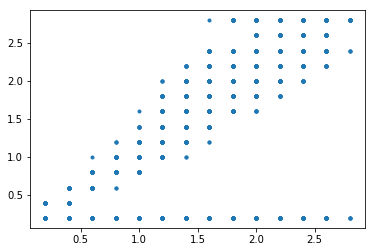

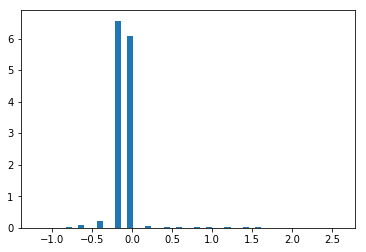

nan
[ 10.14395428  10.6171751    9.54366016   8.79300022   8.35499954
   8.25899982]


In [309]:
print(len(star_bin_vals),len(temp_bin_vals))

star_bin_vals = np.array(star_bin_vals)
temp_bin_vals = np.array(temp_bin_vals)
plt.plot(star_bin_vals,temp_bin_vals,'.')
plt.show()

difference = star_bin_vals-temp_bin_vals

plt.hist(difference,50,normed=True)
plt.show()

print(Gmag[5704] - Kmag[5704])
print(all_starBands[5705])